In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

## Milestone 1
 
We finally have data where discount was randomly assigned. That should handle our problem with bias. However, that's only the first step in personalising. Not only do we want to know the actual average causal effect of discount on profits, we also want to know which type of customer is more sensitive to discounting. 
 
Another thing to consider is that random data is often scarce, compared to non-random data. Hence, it is common to save all the precious random data for model validation, since we can trust it, and use non-random data for model training and estimation. 

### Step 1


In [2]:
train = pd.read_csv("./non_rand_discount.csv", sep=";")
test = pd.read_csv("./random_data.csv")

In [3]:
test.columns

Index(['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby',
       'spend_5m_baby', 'spend_6m_baby', 'spend_1m_clothes',
       'spend_2m_clothes', 'spend_3m_clothes', 'spend_4m_clothes',
       'spend_5m_clothes', 'spend_6m_clothes', 'spend_1m_health',
       'spend_2m_health', 'spend_3m_health', 'spend_4m_health',
       'spend_5m_health', 'spend_6m_health', 'spend_1m_pet', 'spend_2m_pet',
       'spend_3m_pet', 'spend_4m_pet', 'spend_5m_pet', 'spend_6m_pet',
       'spend_1m_groceries', 'spend_2m_groceries', 'spend_3m_groceries',
       'spend_4m_groceries', 'spend_5m_groceries', 'spend_6m_groceries',
       'spend_1m_eletronic', 'spend_2m_eletronic', 'spend_3m_eletronic',
       'spend_4m_eletronic', 'spend_5m_eletronic', 'spend_6m_eletronic',
       'sales', 'discount', 'age', 'gender', 'cust_state', 'tenure', 'profit'],
      dtype='object')

In [4]:
train.columns

Index(['spend_1m_baby', 'spend_2m_baby', 'spend_3m_baby', 'spend_4m_baby',
       'spend_5m_baby', 'spend_6m_baby', 'spend_1m_clothes',
       'spend_2m_clothes', 'spend_3m_clothes', 'spend_4m_clothes',
       'spend_5m_clothes', 'spend_6m_clothes', 'spend_1m_health',
       'spend_2m_health', 'spend_3m_health', 'spend_4m_health',
       'spend_5m_health', 'spend_6m_health', 'spend_1m_pet', 'spend_2m_pet',
       'spend_3m_pet', 'spend_4m_pet', 'spend_5m_pet', 'spend_6m_pet',
       'spend_1m_groceries', 'spend_2m_groceries', 'spend_3m_groceries',
       'spend_4m_groceries', 'spend_5m_groceries', 'spend_6m_groceries',
       'spend_1m_eletronic', 'spend_2m_eletronic', 'spend_3m_eletronic',
       'spend_4m_eletronic', 'spend_5m_eletronic', 'spend_6m_eletronic',
       'sales', 'discount', 'profit', 'age', 'gender', 'cust_state', 'tenure',
       'sales_prediction_bins', 'sales_prediction'],
      dtype='object')

In [5]:
print(train.shape, test.shape)

(15000, 45) (5000, 43)


In [6]:
train.head()

,spend_1m_baby,spend_2m_baby,spend_3m_baby,spend_4m_baby,spend_5m_baby,spend_6m_baby,spend_1m_clothes,spend_2m_clothes,spend_3m_clothes,spend_4m_clothes,...,spend_6m_eletronic,sales,discount,profit,age,gender,cust_state,tenure,sales_prediction_bins,sales_prediction
0,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,3368.64,US$ 125.0,40.06,40,1.0,MA,6,8,1351.024765
1,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2133.10,US$ 75.0,29.52,36,0.0,MG,10,4,1035.580387
2,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2001.62,US$ 50.0,48.08,34,0.0,RJ,7,3,992.401825
3,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,1461.96,US$ 10.0,61.64,31,0.0,BA,7,1,919.720735
4,0,0,0,0,0,0.0,0,0.0,0.0,0.0,...,0.0,2743.72,US$ 100.0,34.44,32,1.0,PB,6,6,1176.485681


After we've cleaned them, both tables have almost the same columns. The non randomized data has two sales prediction columns that are not present in the randomized data.

### Step 2

In [7]:
train["discount"] = train["discount"].str.split(" ").str[-1].astype(float)

### Step 3

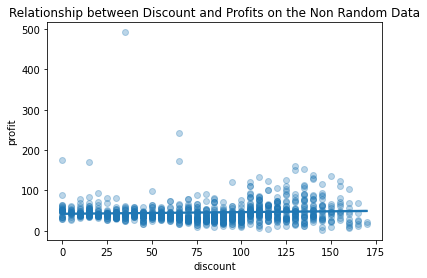

In [8]:
np.random.seed(123) # for reproducibility
sns.regplot(data = train.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Non Random Data");

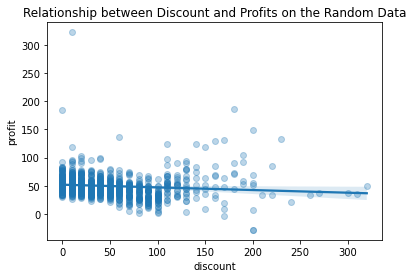

In [9]:
np.random.seed(123) # for reproducibility
sns.regplot(data = test.sample(1000), x="discount", y="profit", scatter_kws={"alpha":0.3})
plt.title("Relationship between Discount and Profits on the Random Data");

The first plot shows a positive relationship between discount and profits. We cannot say this relationship is causal, because there might be confounding variables that were unaccounted for.
 
As for the second plot, it shows a negative relationship between discount and profits. Since discount was randomly assigned in this dataset, we can say that this relationship captures the causal effect of discount on profits.

### Step 4

In [10]:
def elast(data, t, y):
    cov_matrix = np.cov(data[y], data[t])
    return cov_matrix[1, 0] / cov_matrix[1, 1]

In [11]:
print("ATE of discount on sales:", elast(test, "discount", "sales"))
print("ATE of discount on profit:", elast(test, "discount", "profit"))

ATE of discount on sales: 19.286765416028715
ATE of discount on profit: -0.03566112670736013


In [12]:
print("Relationship between discount on sales:", elast(train, "discount", "sales"))
print("Relationship between discount on profit:", elast(train, "discount", "profit"))

Relationship between discount on sales: 21.924806313467585
Relationship between discount on profit: 0.07431475005627178


Looking at the regression coefficient between discount and sales on the data where discounts was randomly assigned, we can see that one unit of discount increases sales by about 19.28. From the introduction of this project, we know that profit is given by
 
$$
Profit_i = Sales_i * 5\% - Discount_i
$$
 
This means that, in order to increase profitability, 1 unit of discount has to increase sales by at more than 20 units ($1/0.05 = 20$). Since that doesn't happen (even though by little) discounting becomes an unprofitable business.
 
As for the relationship we see in the data where discount was not randomly assigned, we can't attribute a causal meaning to it. At least not before considering the forms in which it can be biased,

### Step 5

In [13]:
smf.ols("profit~discount", data=test).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,51.3226,0.390,131.725,0.000,50.559,52.086
discount,-0.0357,0.006,-6.058,0.000,-0.047,-0.024


The coefficient from the univariate regression model matches \\(Cov(t, y)/Var(t)\\). If we look at the confidence interval, we can see it does not contain zero. Hence, the effect of discount on profitability is negative and statistically significant.


## Milestone 2

### Step 1

In [14]:
X = list(train.drop(columns=['sales', 'profit', "cust_state", "discount", "sales_prediction_bins", "sales_prediction"]).columns)
Y = "sales"

### Step 2

In [15]:
np.random.seed(123)
pred_m = LGBMRegressor(max_depth=3)
pred_m.fit(train[X], train[Y])

LGBMRegressor(max_depth=3)

We've trained a ML model to predict sales from customer level features. We've removed features `cust_state` mostly due to laziness. You can include them if you want, but it shouldn't change the results much. Also, we've removed the `discount` feature because, in theory, we don't know the discount level we will give before making sales predictions. You can also include it if you want, but it shouldn't change the result much. 
 
### Step 3

In [16]:
train_pred = train.assign(prediction = pred_m.predict(train[X])) 
test_pred = test.assign(prediction = pred_m.predict(test[X])) 

print("Train Score:", r2_score(train_pred["sales"], train_pred["prediction"]))
print("Test Score:", r2_score(test_pred["sales"], test_pred["prediction"]))

Train Score: 0.8542367421768512
Test Score: 0.42184459036355626


Both train and test set have decent performance. While there is clearly a gap between training and test performance, that is probably due to different discount regimes and not a case of overfitting. Once again, we are not particularly interested in predictive performance here. This is mostly to confirm that the model is not completely off. 
 
### Step 4

In [17]:
sorted_by_pred_test = test_pred.sort_values("prediction", ascending=False)

sorted_by_pred_test[["prediction", "profit", "discount"]].head()

,prediction,profit,discount
2913,8410.140425,389.76,150.0
1736,7171.388857,295.87,300.0
646,6496.265942,322.49,10.0
4354,6404.367544,186.96,180.0
1689,6375.683350,165.58,180.0


In [18]:
print("CATE top 1k:", elast(sorted_by_pred_test.head(1000), "discount", "profit"))
print("CATE botom 1k:", elast(sorted_by_pred_test.tail(1000), "discount", "profit"))

CATE top 1k: -0.09637736244794491
CATE botom 1k: -0.29111205551220626


If we sort our data by sales prediction, take the top 1k customers (highest prediction) and estimate their elasticity we end up with -0.1; if we take the bottom 1k according to the same ordering, we end up with -0.3 (your results may differ a bit depending on your ML model). This means that, first, discounts are **not** profitable in any segment defined by sales predictions. Second, the higher the sales prediction, the **less sensitive customer's profit are to discount**. That is, the lower the sales prediction, the more discount impacts profits in a negative way. 
 


## Milestone 3

### Step 1

In [19]:
test_pred["binary_discount"] = np.where(test_pred["discount"] > 30, 1, 0)

In [20]:
def te(df, t, y):
    return df.query(f"{t}==1")[y].mean() - df.query(f"{t}==0")[y].mean()

In [21]:
ate = te(test_pred, y="profit", t="binary_discount")
ate

-7.955100647304356

The average treatment effect is -8, which means that, if we treat everyone in the test set, we should expect our profits to go down by 8 per customer.

### Step 2

In [22]:
def te_by_segment(df, pred, t, y, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # makes quantile segments
            .groupby(f"{pred}_band")
            .apply(lambda df: te(df, y=y, t=t))) # estimate the treatment effect on each segment

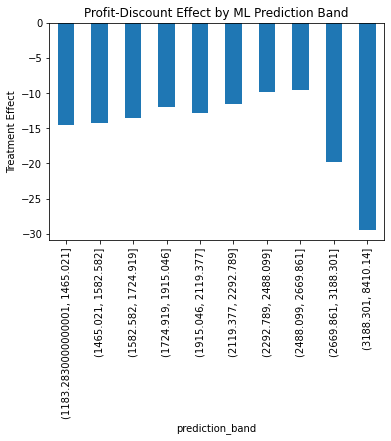

In [23]:
(te_by_segment(test_pred, "prediction", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by ML Prediction Band"))
plt.ylabel("Treatment Effect");

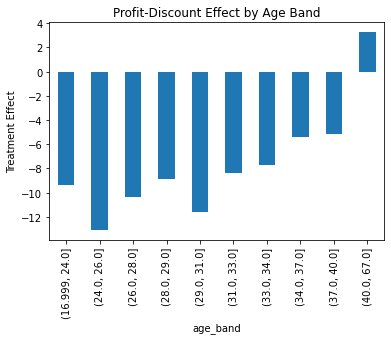

In [24]:
(te_by_segment(test_pred, "age", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by Age Band"));
plt.ylabel(ylabel="Treatment Effect");

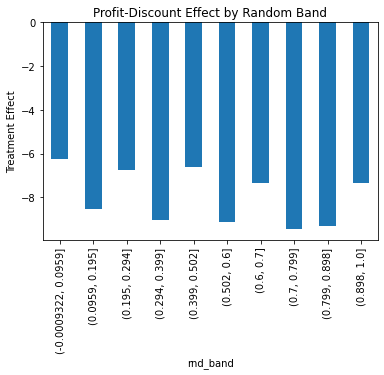

In [25]:
np.random.seed(123)
(te_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
               "rnd", y="profit", t="binary_discount", segments=10)
 .plot.bar(title="Profit-Discount Effect by Random Band"))
plt.ylabel("Treatment Effect");

If we segment the customers by our sales prediction model, we can see that, first, there is no segment where more discounts leads to more profit, since the treatment effect is always negative.
 
Now, take a look at the age segments. First thing we notice is that there is an age segment where discounts are profitable. If we look at segment (40 to 67), the effect of discounts is to increase profits by about 4. This means that, if we segment customers by age, we can find segments where discounts are profitable, something we cannot find with sales prediction segments.
 
Finally, once we segment by a random number, we can see that the treatment effect varies around the average treatment effect, which we found to be about -8. This is expected, since each segment defined by the random number should behave like a representative sample of the entire test set.

### Step 3

In [26]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y) 
                     for row in range(size//steps, size+1, size//steps)])


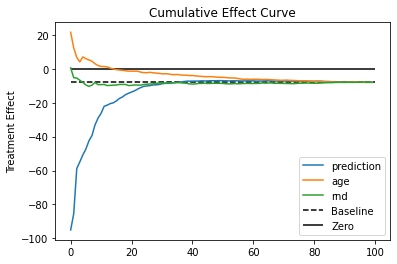

In [27]:
cum_effect_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="binary_discount")
cum_effect_age = cumulative_elast_curve(test_pred, "age", y="profit", t="binary_discount")
cum_effect_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                    "rnd", y="profit", t="binary_discount")

plt.plot(cum_effect_prediction, label="prediction")
plt.plot(cum_effect_age, label="age")
plt.plot(cum_effect_rnd, label="rnd")
                                       
plt.hlines(ate, 0, 100, linestyle="--", color="black", label="Baseline")
plt.hlines(0, 0, 100, linestyle="solid", color="black", label="Zero")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Effect Curve")
plt.legend();

The cumulative effect curve tells a similar story from the one we've seen before, in the effect by segment step. Ordering customers by sales prediction will always yield treatment effects below the zero line. However, if we look by age, we can see that the top 20% older customers have a positive discount effect on profit. This tells us that simply segmenting customers by age and sending discounts to older customers is a better personalisation strategy than a complex ML model. 
 
In the black dotted line, I've also shown the average treatment effect to see what would happen if we were to not segment at all. Since this line is below zero, it means that, on average, without personalising, discounts are not profitable. Also, notice how the random segmentation fluctuates around the ATE, as expected. 


### Step 4

In [28]:
def cumulative_gain(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([te(ordered_df.query(f"index<={row}"), t=t, y=y)*row/size 
                     for row in range(size//steps, size+1, size//steps)])


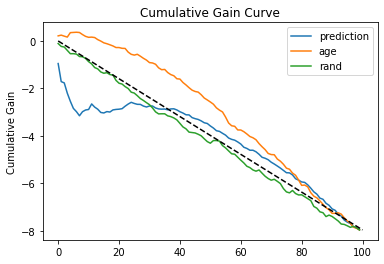

In [29]:
np.random.seed(123)

gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="binary_discount")
gain_age = cumulative_gain(test_pred, "age", y="profit", t="binary_discount")
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="binary_discount")

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_rand, label="rand")

plt.plot([0, 100], [0, ate], linestyle="--", color="black")


plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The cumulative gain tells a similar story. This curve is harder to interpret but it's the most convenient one to compare different strategies. The higher the curve (more to the top right corner), the better the personalisation strategy. Looking at it, we can clearly see that personalising by age is a much better idea than personalising by a ML model that predicts sales. 
 
Again, the random model fluctuates around the baseline.

## Milestone 4

### Step 1

In [30]:
def elast_by_segment(df, pred, y, t, segments=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=segments)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(lambda df: elast(df, y=y, t=t))) # estimate the elasticity on each partition

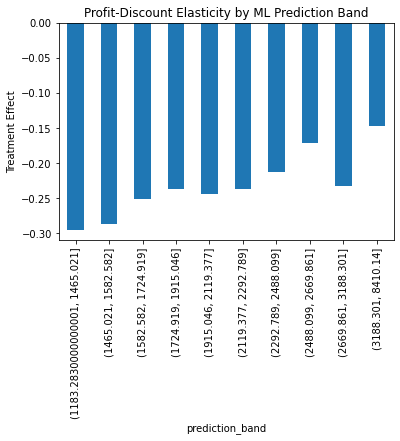

In [31]:
(elast_by_segment(test_pred, "prediction", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by ML Prediction Band"))
plt.ylabel("Treatment Effect");

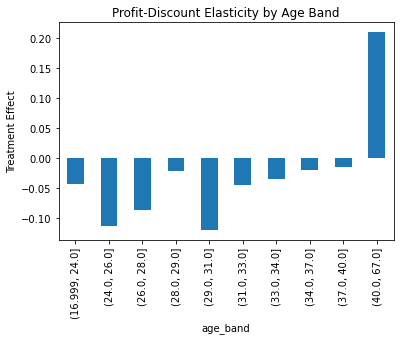

In [32]:
(elast_by_segment(test_pred, "age", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by Age Band"));
plt.ylabel(ylabel="Treatment Effect");

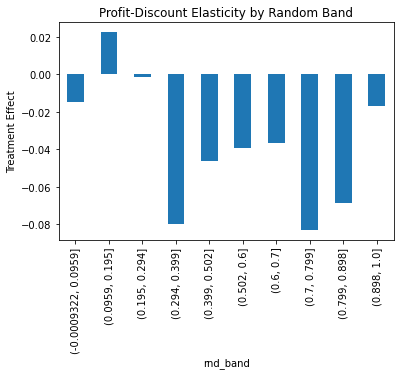

In [33]:
np.random.seed(123)
(elast_by_segment(test_pred.assign(rnd=np.random.uniform(0,1,test.shape[0])),
                  "rnd", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by Random Band"))
plt.ylabel("Treatment Effect");

If we segment the customers by our sales prediction model, we can see that, first, there is no segment where more discounts leads to more profit. Second, the higher the sales prediction, the less profit suffers from more discount. In other words, the treatment effect becomes less negative as sales prediction increases
 
Now, take a look at the age segments. First thing we notice is that there is an age segment where discounts are profitable. If we look at segment (40 to 67), we should expect profit to **increase** \\\$0.2 for every \\\$1.0 invested in discount (remember that \\(Profit = 0.5 Sales - Discount\\), so every \\\$1 spend will generate \\\$1.2 in revenues and hence, \\\$0.2 in profits). This means that, if we segment customers by age, we can find segments where discounts are profitable, something we cannot find with sales prediction segments.
 
Finally, once we segment by a random number, we can see that the treatment effect varies from positive to negative, but always very small numbers. This is probably noise, since in theory, the treatment effect of a random segment should match the ATE, which we know is negative.


### Step 2

In [34]:
def cumulative_elast_curve(dataset, prediction, y, t, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y) 
                     for row in range(size//steps, size+1, size//steps)])



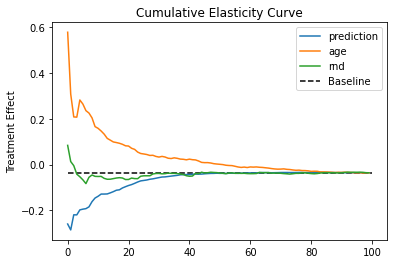

In [35]:
cum_elast_prediction = cumulative_elast_curve(test_pred, "prediction", y="profit", t="discount")
cum_elast_age = cumulative_elast_curve(test_pred, "age", y="profit", t="discount")
cum_elast_rnd = cumulative_elast_curve(test_pred.assign(rnd=np.random.uniform(0, 1, test.shape[0])),
                                       "rnd", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="prediction")
plt.plot(cum_elast_age, label="age")
plt.plot(cum_elast_rnd, label="rnd")
                                       
plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Elasticity Curve")
plt.legend();

The cumulative elasticity curve tells a similar story from the one we've seen before. Ordering customers by sales prediction will only always yield treatment effects below the zero line. However, if we look by age, we can see that the top 40% older customers have a positive discount effect on profit. This tells us that simply segmenting customers by age and sending discounts to older customers is a better personalisation strategy than a complex ML model. 
 
In the black dotted line, I've also shown the average elasticity to see what would happen if we were to not segment at all. Since this line is below zero, it means that, on average, without personalising, discounts are not profitable. Also, notice how the random segmentation fluctuates around the ATE, as expected. 

### Step 3

In [36]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100, ascending=False):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=ascending).reset_index(drop=True)
    return np.array([elast(ordered_df.query(f"index<={row}"), t=t, y=y) * (row/size) 
                     for row in range(size//steps, size+1, size//steps)])


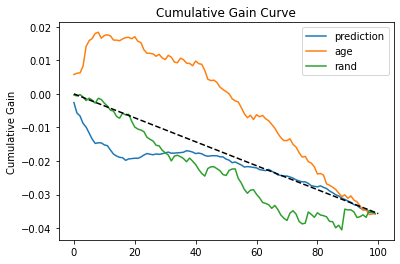

In [37]:
np.random.seed(123)
gain_prediction = cumulative_gain(test_pred, "prediction", y="profit", t="discount", ascending=False)
gain_age = cumulative_gain(test_pred, "age", y="profit", t="discount", ascending=False)
gain_rand = cumulative_gain(test_pred.assign(rand=np.random.uniform(0, 1, test.shape[0])),
                            "rand", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_rand, label="rand")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")


plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The cumulative gain tells a similar story. This curve is harder to interpret but it's the most convenient one to compare different strategies. The higher the curve (more to the top right corner), the better the personalisation strategy. Looking at it, we can clearly see that personalising by age is a much better idea than personalising by a ML model that predicts sales. 
 
Again, the random model fluctuates around the baseline.

## Milestone 5

### Step 1

In [38]:
teh_model = smf.ols("profit~discount*(tenure+age+C(cust_state))", data=train).fit()

### Step 2

In [39]:
test_te = teh_model.predict(test) - teh_model.predict(test.assign(discount=test["discount"]-1))

test_pred["teh_model"] = test_te

### Step 3

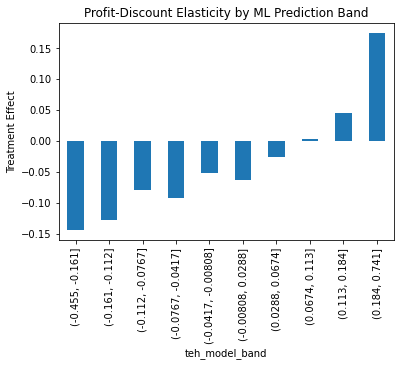

In [40]:
(elast_by_segment(test_pred, "teh_model", y="profit", t="discount", segments=10)
 .plot.bar(title="Profit-Discount Elasticity by ML Prediction Band"))
plt.ylabel("Treatment Effect");

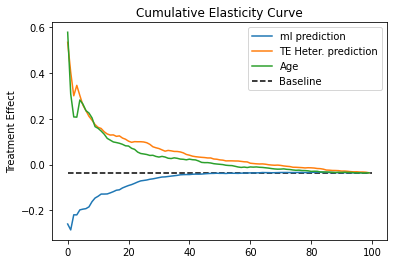

In [41]:
cum_elast_teh = cumulative_elast_curve(test_pred, "teh_model", y="profit", t="discount")

plt.plot(cum_elast_prediction, label="ml prediction")
plt.plot(cum_elast_teh, label="TE Heter. prediction")
plt.plot(cum_elast_age, label="Age")
                                       
plt.hlines(elast(test_pred, "discount", "profit"), 0, 100, linestyle="--", color="black", label="Baseline")
plt.ylabel("Treatment Effect")
plt.title("Cumulative Elasticity Curve")
plt.legend();

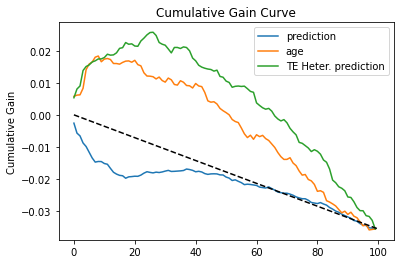

In [42]:
gain_teh = cumulative_gain(test_pred, "teh_model", y="profit", t="discount", ascending=False)

plt.plot(gain_prediction, label="prediction")
plt.plot(gain_age, label="age")
plt.plot(gain_teh, label="TE Heter. prediction")

plt.plot([0, 100], [0, elast(test_pred, "discount", "profit")], linestyle="--", color="black")

plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain Curve")
plt.legend();

The Elasticity or TE by Band plots shows that the model orders the treatment effect nicely, even in a dataset which it didn't see during the fitting process. As we can see, customers with high TE prediction indeed have high TE in the data where discount was randomized. Also, customers with low TE prediction have, indeed, low TE.
 
The cumulative elasticity curve shows that our TE model starts further from the ATE and converges slowlier to it. This means that the model is better at distinguishing customers with high TE from those with low TE. It's better than simply using Age, but not by much. The cumulative gain plot shows a similar picture, with our model coming on top once again.

### Step 4

Based on the plot Treatment Effect by Band plot (from step 3), it makes sense to treat everyone with treatment effect predictions above 0.067. You could also choose to treat everyone with treatment effect prediction above zero, if you really trust you scores. 